
### <center> AEM 649 Project </center>
# <center> Fatigue Property Calculation & Damage Estimation </center>


### <center> Dr. Mark Barkey </center>
### <center> AEM 659 </center>
### <center> Spring 2018 </center>
    
###  <center> by. Brennan White </center>
 
## Preface

### Python for Data Analysis 
The entire project was done in python, using the data frame type from `pandas`. Below, more details for each package used are below: 

### Python Package Imports
* `pandas`: the dataframes format (df) of pandas is used to collect, organize, and filter the data
* `numpy`: the methods and conveniences of numpy are used for mathematical operations
* `matplotlib`: this is the plotting package used for plotting data
* `ipywidgets` and `%matplotlib notebook` allow for interactive charts with slider widgets
* `scipy` is used as the solver for non-linear equations

### Jupyter Notebooks
The specific IDE utilized for this project is Jupyter Notebooks. The software for the notebook was installed via Anaconda. The notebook is made up of individual cells that can run python live. The code presented in this notebook may well work in python run from the terminal, but it is specifically designed to be run in a jupyter notebook. Some modifications may be required to run the code in a typical python fashion.

_It should also be noted that the python code presented here does not necessarily follow strict python guidelines as is not intended to be run as a program/script per-se._

## Phase 1

    1. Plot the given data
    2. Find the max for each data set and rearrange to make the data start and end with the max value
    3. Clean up the data to show only the local min and max data points (points of inflection)
    4. Plot the new data

   

In [1]:
from math import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
#from sympy import *
#init_printing(use_unicode=False, wrap_line=False, no_global=True, use_latex='mathjax')
from scipy.optimize import fsolve

### Putting Data Into Dataframes
The data is given in CSV format, which can be imported directly to a dataframe using `pandas`. The row index is assumed to correspond to time $t$ in some consistent unit between data sets. The index is copied to a new colume called time for future comparisons of data sets. 

In [2]:
df_pothole = pd.read_csv("Data/FILE1-pothole.txt", header = None, names = ['strain'])
df_roughroad = pd.read_csv("Data/FILE2-roughroad.txt", header = None, names = ['strain'])
df_pothole['time'] = df_pothole.index.values
df_roughroad['time'] = df_roughroad.index.values
df_pothole_endTime = np.max(df_pothole['time'])
df_roughroad_endTime = np.max(df_roughroad['time'])

### 1.1 Plotting The Given Data
After organizing the data into dataframes, it can then easily be plotted.

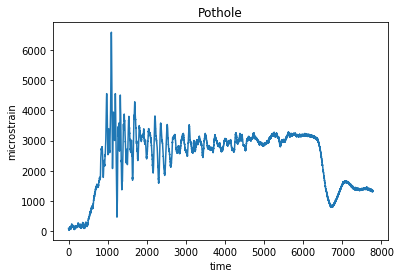

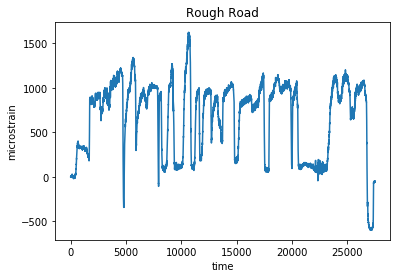

In [3]:
label_x = 'time'; label_y = 'microstrain'
#figsize=(20,5)
plt.figure(1);
plt.subplot(111)
plt.plot(df_pothole['strain']); plt.title('Pothole');plt.ylabel(label_y); plt.xlabel(label_x)

plt.figure(2); plt.subplot(111)
plt.plot(df_roughroad['strain']); plt.title('Rough Road');plt.ylabel(label_y); plt.xlabel(label_x)

plt.show()

### 1.2 Find the Max and Re-arrange the Data
The function below `sort_max2max` is used to section the data from 0 to the max, and max to the end. The two segments are then re-combined so that it will start with and end with the max. The method is then applied to both data sets (referred to in a short-hand notation at this point). 

In [4]:
def set_timescale(df):
    ''' 
    Objective: Adjusts the "time" column of dataframe to match original end time with adequate spacing
               This is required to plot vs. orginal data after smoothing out the data set. Else, the 
               effective time would be shorter when plotted strain vs. index as there are fewer points.
    Arguments: df is of type pandas.dataframe
    Returns  : dataframe with additional time column 
    '''
    if np.max(df['time']) == df_roughroad_endTime:
        endTime = df_roughroad_endTime
    elif np.max(df['time']) == df_pothole_endTime:
        endTime = df_pothole_endTime
    df['time'] = np.linspace(0, endTime+1, num=len(df))

In [5]:
def sort_max2max(df):
    df_start_to_max = df.iloc[:df[df.strain == np.amax(df['strain'])].index[0]]
    df_max_to_end = df.iloc[df[df.strain == np.amax(df['strain'])].index[0]:]
    df = pd.concat([df_max_to_end, df_start_to_max])
    df.at[len(df),'strain'] = int(np.amax(df['strain'])) # Add the max value to the end
    df = df.reset_index(drop='True')
    set_timescale(df)
    return df

In [6]:
df_p = df_pothole
df_r = df_roughroad
df_p1 = sort_max2max(df_p)
df_r1 = sort_max2max(df_r)

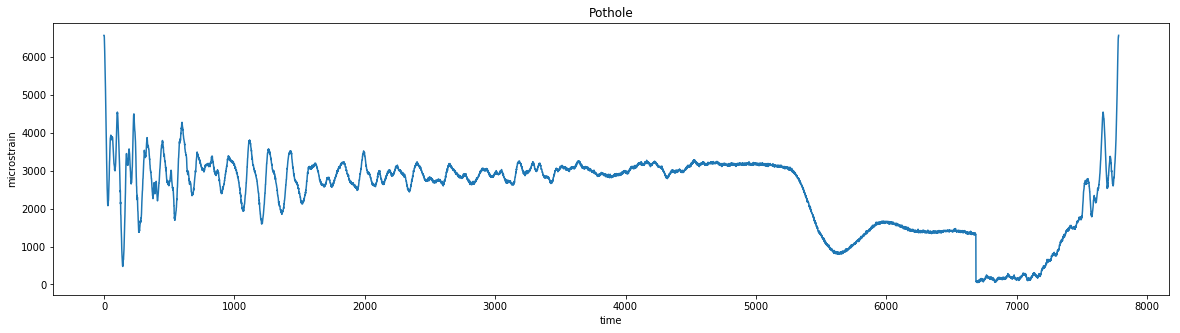

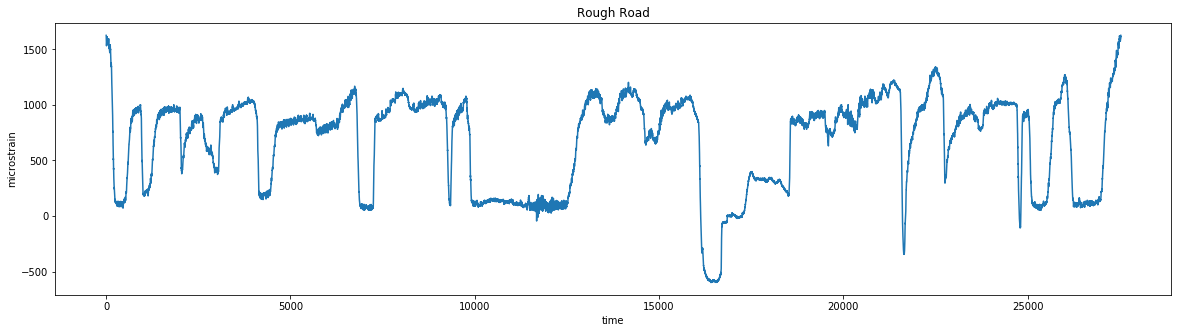

In [7]:
plt.figure(3, figsize=(20,5)); plt.subplot(111)
plt.plot(df_p1['strain']); plt.title('Pothole');plt.ylabel(label_y); plt.xlabel(label_x)

plt.figure(4, figsize=(20,5)); plt.subplot(111)
plt.plot(df_r1['strain']); plt.title('Rough Road');plt.ylabel(label_y); plt.xlabel(label_x)

plt.show()

### 1.3 Clean Up the Data by Removing Points Between Local Max and Min

This is accomplished using three methods: `remove_duplicates()`, `find_inflection_points()`, and finally `smooth_data()`. Each method accepts a numpy DataFrame as the argument and returns a modified data frame.

#### `remove_duplicates()`
Sequential duplicates represent the same peak or valley and need to be removed. This method compares each value to the next value in the data frame. The data frame is then filtered to exclude points where `Duplicate == True`. This prevents the algorithm from incorrectly identifying a duplicate point as an inflection point.

#### `find_inflection_points()`
Inflection points are where the sign of the slope changes. This indicates the data point is a local max or min and should be retained.

In [8]:
def remove_duplicates(df):
    ''' 
    Objective: Removes sequential duplicates from a pandas dataframe
    Arguments: df is of type pandas.dataframe
    Returns  : dataframe without sequential duplicates
    '''
    df['duplicate'] = False
    df.duplicate = df.strain==df.strain.shift(1)
    df.at[len(df)-1,'duplicate'] = False             # Keep max at end
    df = df[df['duplicate'] == False]
    return df

In [9]:
def find_inflection_points(df):
    ''' Identifies local max/min values based on a change in slope direction in "strain" column of df'''
    df['slope'] = 0                                  # Add a new column to df for slope, default value is 0
    df['inflection'] = False                         # Add a new column for inflection pt, default is False
    try:                                             # Attempt to calculate to slope and skip if not possible
        df.slope = (df.strain-df.strain.shift(1))    # Slope based on index
    except:
        next
    df.inflection = df.slope/df.slope.shift(-1)<0    # If the slope changes, this is an inflection point
    df.at[0,'inflection'] = True                     # Make sure to keep max at begining
    df.at[len(df)-1,'inflection'] = True             # Keep max at end
    df = df[df['inflection'] == True]                # Keep only inflection points
    return df

#### `smooth_data()`
To implement both the removal of duplicates and finding inflection points in a loop, they are both encompassed in `smooth_data()`. This method takes and argument of type data frame, captures the initial length, then begins removing points based on the previously mentioned methods.

In [10]:
def smooth_data(df, verbose=False):
    ''' Implements both remove_dupicates() and find_inflection_points() inside of a while loop'''
    start_len = len(df)
    if verbose: print(
        'Data frame starting with {} lines.'.format(start_len))
    end_len = 0
    start_len = 1
    while True:
        start_len = len(df)                 # Capture start length
        df = df.reset_index(drop = 'True')  # Reset index
        df = remove_duplicates(df)          # Remove duplicates points in sequence, else inflection fails
        df = find_inflection_points(df)     # Find inflection points based on the slope change
        end_len = len(df)                   # Capture end length
        if start_len == end_len:            # Don't loop again if no data points were removed this time
            if verbose: print(' COMPLETE');print()
            break
        else:
            if verbose: print(' ...The data frame was shortened from {} lines to {}'.format(start_len,end_len))
    return df

In [11]:
df_p2 = smooth_data(df_p1)
df_r2 = smooth_data(df_r1)

In [12]:
# If needed, use these to check the slice outputs of the data frames
#df_r1_endTime['time']
#df_p2[:15]

After removing a significant number of data point, the plots maintain the same shape when plotted on top of one another.

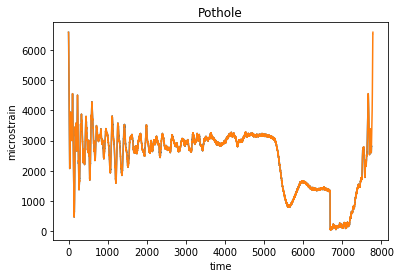

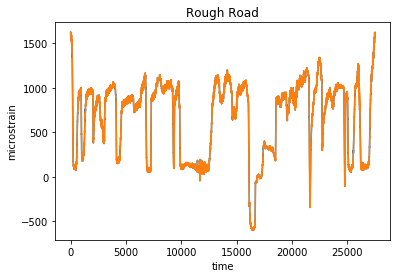

In [13]:
plt.figure(5); plt.subplot(111)
plt.plot(df_p2['time'],df_p2['strain']);plt.plot(df_p1['strain'])
plt.title('Pothole');plt.ylabel(label_y); plt.xlabel(label_x)

plt.figure(6); plt.subplot(111)
plt.plot(df_r2['time'],df_r2['strain']);plt.plot(df_r1['strain'])
plt.title('Rough Road');plt.ylabel(label_y); plt.xlabel(label_x)

plt.show()

In [14]:
df_p2["strain"].to_csv("Data/FILE1-pothole_smooth.txt", index=False)
df_r2["strain"].to_csv("Data/FILE1-roughroad_smooth.txt", index=False)

In [15]:
#Test Output
df = df_p2
df.iloc[-1].strain

2816.0

## Phase 2
    1. Determine cyclic properties (k’, n’) for 1070 steel from data set supplied.
    
    2. Plot hysteresis loops provided; compare to your calculated constants and the monotonic RO curve using your cyclic stress-strain properties.
    
    3. Use Massing’s hypothesis (hysteresis branch equation) to see how well your constants do with modeling the branches of the hysteresis loop test data.
    
    4. Determine strain-life fatigue constants for MS6000 sheet steel using data set supplied.
    
    5. Include plots that show how well your 1070 properties fit to the experimental data and Massing’s hypothesis. Include a plot for the MS6000 sheet steel to show how well your constants fit to the experimental data.

The data is read from the given CSV files by using `Pandas`. Each data set is used to generate a data frame. All of the data frame are put together as a list in `dfs_1070` (data frames for 1070).

In [16]:
names_1070 = ['stress','axial_strain', 'dia_strain']
df_10 = pd.read_csv("Data/1070/10.txt", names = names_1070, sep=" ")
df_A2 = pd.read_csv("Data/1070/A2.txt", names = names_1070, sep=" ")
df_A4 = pd.read_csv("Data/1070/A4.txt", names = names_1070, sep=" ")
df_A6 = pd.read_csv("Data/1070/A6.txt", names = names_1070, sep=" ")
df_A8 = pd.read_csv("Data/1070/A8.txt", names = names_1070, sep=" ")
df_B2 = pd.read_csv("Data/1070/B2.txt", names = names_1070, sep=" ")
df_B4 = pd.read_csv("Data/1070/B4.txt", names = names_1070, sep=" ")
df_B6 = pd.read_csv("Data/1070/B6.txt", names = names_1070, sep=" ")
df_B8 = pd.read_csv("Data/1070/B8.txt", names = names_1070, sep=" ")
dfs_1070 = [df_A2,df_A4,df_A6,df_A8,df_10,df_B8,df_B6,df_B4,df_B2]

### 2.1 
The cyclic properties $K'$ and $n'$ can be determined by creating a best-fit line to the log-log plot of plastic strain amplitude vs stress amplitude. In order to do so, the data frames created need to be manipulated.

#### `calc_stress_amps(df)`
This method takes a data frame from a list of data frames and does the following:
1. Find the max and min stresses.
2. Calculates the stress amplitude 
3. Appends the max, min, and amp values to the appropriate list


#### `add_stress_strain_amps(dfs)` 
This method builds a single data frame with stress and strain amplitudes (calculated using `calc_stress_amps()`). The 
method utilizes a list of given strain amplitudes and also labels each data set using the `set_list` argument. If neither is given, the method will not put anything in those columns.


In [17]:
# Additional Given Information
E_1070 = 210000 #MPa
strain_amps = [0.002,0.004,0.006,0.008,.01,.008,.006,.004,.002]
set_list = ['A2','A4','A6','A8','10','B8','B6','B4','B2']

In [18]:
def calc_stress_amps(dfs):
    stress_amps, max_stresses,min_stresses  = [],[],[]
    for df in dfs:
        sigma_max = np.max(df['stress'])
        sigma_min = np.min(df['stress'])
        stress_amp = (sigma_max - sigma_min)/2
        max_stresses.append(sigma_max)
        min_stresses.append(sigma_min)
        
        if abs(sigma_min) > abs(sigma_max):
            stress_amp = stress_amp * -1.0
        stress_amps.append(stress_amp)
    return stress_amps, max_stresses,min_stresses

In [19]:
def add_stress_strain_amps(dfs,strain_amps=[],set_list=[],E=1):
    '''
    Takes a series of pd.DataFrames and returns a single data 
    frame with the stress and strain amplitudes 
    '''
    stress_amps, max_stresses,min_stresses = calc_stress_amps(dfs)
    df = pd.DataFrame(
    columns = ['max_stress','min_stress','stress_amp','min_strains',
               'max_strains','strain_amp','strain_amp_C','data_set',
               'esp_p'])
    df.max_stress = max_stresses
    df.min_stress = min_stresses
    df.stress_amp = stress_amps
    if strain_amps: df.strain_amp = strain_amps
    if set_list: df.data_set = set_list
    df.esp_p = df.strain_amp - df.stress_amp/E
    return df

In [20]:
df_all = pd.concat(dfs_1070).reset_index(drop='True')
df_amps = add_stress_strain_amps(dfs_1070,strain_amps,set_list,E_1070)
df_amps['CF'] = (df_amps.max_stress-df_amps.stress_amp)/2
CFs = list(df_amps['CF'])

Now that the data frame for amplitude is set up, the values can be plotted. A copy of `df_amps` is created here to use specifically for this plot. Some of the data sets may deviate highly from the best fit line. The data set name of those points can be included in the list `remove these`, which is then implemented in `clean_df()`

In [21]:
def clean_df(df,list_to_remove):
    for each in list_to_remove:
        df = df[df['data_set'] != each] #remove mostly elastic data
    return df

In [22]:
df2 = df_amps.copy()
remove_these = ['A2']
df2 = clean_df(df2,remove_these)

#### Numerical Solution
After creating the dataframe with the amplitudes, x & y values can be extracted. The numpy packages polyfit can be used to solve for the numerical solution. Given that $ \frac{\Delta \epsilon_p}{2} = K \left( { \frac{\Delta \sigma}{2}  }\right)^{n'} $ taking the log of both sides and solving the linearized equation returns $ln(K')$ and $n'$. 

In [23]:
# Pull out the x and y data from the data frame
x2 = df2['esp_p']
y2 = df2['stress_amp']

# Numerical Solution
n,K = np.polyfit(np.log(x2), np.log(y2),1)
Kpr = np.exp(K)
npr = n
y_fit = Kpr*x2**npr # Series of points to fit data based on solution

#### Plot and Graphical Solution
In addition to the numerical solution, the problem can also be solved graphically. The plot below implements interactive features of `matplotlib` that allow the user to alter the K' and n' values to see how the best fit line is adjusted. The initial values for each are set to the numerical solution. 

In [24]:
#%matplotlib notebook # Utilize this when not runnning a jupyter notebook

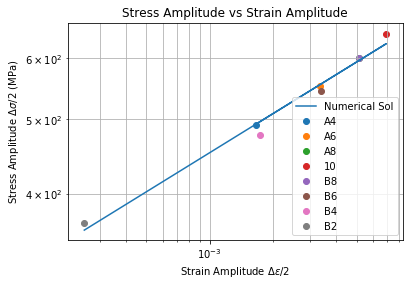

In [25]:
fig = plt.figure() # New figure
ax = fig.add_subplot(1, 1, 1)


# Plot Formatting
plt.yscale('log');plt.xscale('log')
plt.title('Stress Amplitude vs Strain Amplitude')
plt.ylabel('Stress Amplitude ${\Delta \sigma}{/2}$ (MPa)')
plt.xlabel('Strain Amplitude ${\Delta \epsilon}{/2}$')
plt.grid(True,'both')
plt.grid(True,'minor')

# Different color for each data set
cmap = plt.cm.coolwarm
labs = list(df2['data_set'])
N = len(labs)
i = 0
cols = cmap(np.linspace(0, 1, N))
for each in x2:
    plt.scatter(list(x2)[i], list(y2)[i], label=labs[i])
    i+=1
plt.plot(x2,y_fit,
         label='Numerical Sol')
plt.legend(loc='lower right')
plt.show()

# # Graphical Solution
# line, = ax.plot(x2, y2, color='red', linestyle='dotted', label="Graphical Sol")
# def update(K = Kpr,n_x100 = npr*100):
#     line.set_ydata(K*x2**(n_x100/00))
#     fig.canvas.draw()

# #interact(update);

### 2.2 Plot the Hystereiss Loops for the Data Given

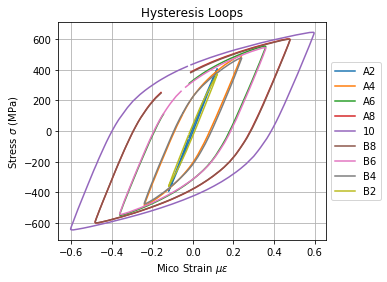

In [26]:
set_list = ['A2','A4','A6','A8','10','B8','B6','B4','B2']
i = 0
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)

# Plot a loop for each DF in the set
for df in dfs_1070:
    stress = df['axial_strain']*10*6
    strain = df['stress']-CFs[i]
    label = set_list[i]
    ax.plot(stress,strain, label=label)
    i += 1

# Label the plot
plt.title('Hysteresis Loops')
plt.xlabel('Mico Strain $\mu\epsilon$')
plt.ylabel('Stress $\sigma$ (MPa)')

stress = df_all['stress']

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.grid(True, 'both')
#plt.show()

In [27]:
def RO_stress(e, E, Kp, np):
    '''
    e = strain, E = mozdulus of elasticity, Kp = K', np = n'
    Returns the stress that gives the same strain.
    '''
    s_guess = 5
    def strain_diff(stress):
        '''The difference between Ramburg Osgood strain and given strain'''
        return stress/E+(stress/Kp)**(1/np) - e
    stress = fsolve(strain_diff, s_guess)
    return stress[0]

In [28]:
def HB_stressAmp(ea, E, Kp, np):
    '''
    ea = strain amplitude, E = mozdulus of elasticity, Kp = K', np = n'
    Returns the stress amplitude that gives the same strain.
    '''
    sa_guess = 5
    def strain_amp_diff(sa):
        return sa/E+(sa/Kp)**(1/np) - ea
    stress_amp = fsolve(strain_amp_diff, sa_guess)
    return stress_amp[0]

In [29]:
def RO_strain(s, E, Kp, np):
    '''s = stress, E = mozdulus of elasticity, Kp = K', np = n'''
    return s/E+(s/Kp)**(1/np)

In [30]:
def HB_strain(sA,E,Kp = Kpr,np = npr):
    return sA/E+(sA/Kp)**(1/np)

#### `hysteresis_loop()`
This method takes a list of stresses and calculates the points of the hysteresis loops using the Ramburg Osgood equation for the initial point, and the Hystereiss Branch equation for subsequent points.

In [31]:
def hyst_loop(stresses, E=1, Kpr=Kpr, npr=npr,verbose=False):
    result = pd.DataFrame(
        columns=['Point','Stress','Strain','Strain_Amp','Stress_Amp'])
    strains = []; status = ""
    strains.append(RO_strain(stresses[0], E, Kpr, npr))
    result = result.append(
        {'Point':1,
         'Stress':stresses[0],
         'Strain':strains[0],
         'Strain_Amp':0,
         'Stress_Amp':0},
        ignore_index=True)
    
    for i in range(1,len(stresses)-1):
        stress_amp = (stresses[i]-stresses[i-1])/2
        status += (
            '\n previous stress: {} + ' +
            'stress_amp {} * 2 = {}'.format(stresses[i-1],
                                            stress_amp*2,
                                            stresses[i]))
        
        # There is a problem with evaluating the formula for 
        # a negative stress amplitude, so make positive 
        if stress_amp >= 0:
            strain_amp = HB_strain(stress_amp,E)
        else:
            strain_amp = -1*(abs(stress_amp)/E + (abs(stress_amp)/Kpr)**(1/npr))
            strain_amp = -1*HB_strain(abs(stress_amp),E)
        
        strains.append(strains[i-1]+(strain_amp*2))
        status += (
            '\n previous strain: {} + '+
            'strain_amp {} * 2 = {}'.format(strains[i-1],
                                            strain_amp*2,
                                            strains[i]))
        result = result.append(
            {'Point':i+1,
             'Stress':stresses[i],
             'Strain':strains[i],
             'Strain_Amp':strain_amp,
             'Stress_Amp':stress_amp},
            ignore_index=True)
    if verbose:
        #print(status)
        print('*** HB RESULTS ***')
        print(result)
    stress_amps = result['Stress_Amp']
    strain_amps = result['Strain_Amp']
    return strain_amps, stress_amps

Compare the plots of 1070 hysteresis loops to the hysteresis branch equation values generated for using the determined n' and K' with only stress amplitudes of the 1070 data.

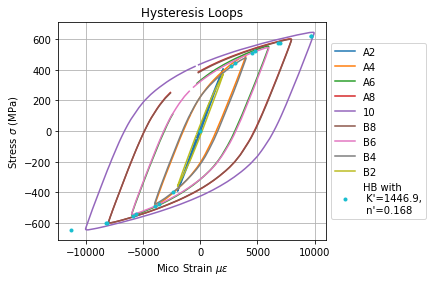

In [32]:
set_list = ['A2','A4','A6','A8','10','B8','B6','B4','B2']
i = 0
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)

# Use slices to select which of the data sets to plot
slice_start = 0
slice_end = len(set_list)
stresses_x = []

# Plot a loop for each chosen set
# allows the user to use slices to decide which loops to plot
for df in dfs_1070[slice_start:slice_end]:                     
    strain = df['axial_strain']*10**6
    stress = df['stress']-CFs[i]
    label = set_list[slice_start:slice_end][i]
    stresses_x.append(max(stress.tolist()))
    stresses_x.append(min(stress.tolist()))
    ax.plot(strain,stress, label=label)
    i +=1

# Label the plot
plt.title('Hysteresis Loops')
plt.xlabel('Mico Strain $\mu\epsilon$') 
plt.ylabel('Stress $\sigma$ (MPa)')


hb_strain, hb_stress = hyst_loop(stresses_x,E_1070)
ax.plot(hb_strain*10**6,hb_stress,
        '.',label="HB with \n K'={},\n n'={}".format(round(Kpr,1),round(npr,3)))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.grid(True, 'both')
#plt.show()     # Not needed when using %matplotlib notebook

### 2.4 MS6000 Material Properties

As done with previous sections, the properties are read from a text file and stored in a dataframe. This particular data set requires the addition of a defined separator and parsing engine. 

In [33]:
names_MS6000 = ['eps','sig', 'Nf','eps_plastic']
E_MS = 29500
df_MS = pd.read_csv("Data/MS6000.txt", 
                    header = None, 
                    names = names_MS6000, 
                    sep="\t\t", 
                    engine='python')
df_MS['rev'] = df_MS['Nf'].astype(float)*2
df_MS = df_MS[:-3] # remove the last 3 data points

#### Strain Life Equations

There are three lines to plot: elastic, plastic and total.

In [34]:
def elastic(rev):
    return sig_f/E_MS*rev**b
def plastic(rev):
    return eps_f*rev**c
def total(rev):
    return sig_f/E_MS*rev**b + eps_f*rev**c

The given axial strain values are given as total and plastic, the elastic portion being the difference between the total and plastic. The values here are stored as a `pandas` Series built from the columns of the data frames. Each fo these 

In [35]:
y_e = df_MS['eps']-df_MS['eps_plastic']
y_p = df_MS['eps_plastic']
y_t = df_MS['eps']
x = df_MS['rev']

Similarly to the earlier determination of n' and K', the values for b, c, $\epsilon_f$ and $\sigma_f$ can be determined from a fit of strain amplitude to the number of reversals to failure, $N_f$. This is accomplished using `np.polyfit()`. 

In [36]:
E = E_MS
b,sig_f= np.polyfit(np.log(x),np.log(y_e),1)
sig_f = np.exp(sig_f)*E_MS

c,eps_f = np.polyfit(np.log(x),np.log(y_p),1)
eps_f = np.exp(eps_f)

#### Plot the Given Data and Fit Lines

For the x axis of the fit lines, use `np.linspace` to generate a data series. This method takes arguments for the start, end, and number of data points. 

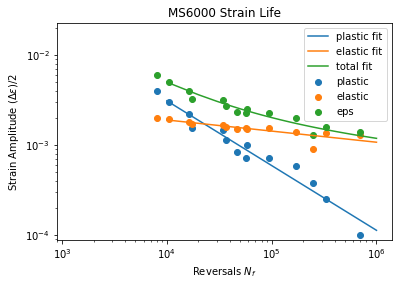

In [37]:
fig3 = plt.figure()
ay = fig3.add_subplot(1,1,1)

# Plot the given data
ay.scatter(x,y_p,
           label='plastic')
ay.scatter(x,y_e,
           label='elastic')
ay.scatter(x,y_t)

# Plot the fit lines
revs = np.linspace(10**4,10**6,100)
ay.plot(revs,plastic(revs),
        label='plastic fit')
ay.plot(revs,elastic(revs),
        label='elastic fit')
ay.plot(revs,total(revs),
        label='total fit')

# Format the plot
plt.yscale('log')
plt.xscale('log')
plt.title('MS6000 Strain Life')
plt.xlabel('Reversals $N_f$')
plt.ylabel('Strain Amplitude $(\Delta \epsilon)/2$')
ay.legend()
plt.show()


## Phase 3 & Phase 4
1. Produce Newton-Raphson solver for use for RO equation and strain-life equations, or learn how to use equation solvers in your programming language as applicable.
2. Implement case I hysteresis loop calculator for several levels of strain (fully reversed, constant amplitude loading, strain controlled) as discussed in class.
3. Implement full Case I-III for hysteresis loop calculator--this is a big step.
4. Implement strain-life damage parameter and Miner's rule for damage accumulation.


In [69]:
def three_point_loop(peak_list, *args, **kwargs):
    peaks = peak_list.copy()
    
    # Max and Min are used for final loop
    max_peak = max(peaks)
    min_peak = min(peaks)
    
    # Obtain Initial Values
    A = peaks.pop(0)
    B = peaks.pop(0)
    C = peaks.pop(0)
    
    # Establish Variables
    loops = 0       # Loop counter
    storage = []    # Empty list to be used to store points
    v_list = [      # List of args to set verbose output
        'v', 'verb','verbose']
    verbose = False # Non-verbose by default
    
    for arg in args: # Check for *args
        if arg in v_list: verbose = True
    ranges = pd.DataFrame(columns=['Start','End','Range'])
    
    # Begin printout
    if verbose:
        print('* \t ***** STARTING CYCLE COUNTER ***** \t *')
        print('* \t*C* = cycle, *X* = no closed loop')
        print('*'*50)
        print()
    
    # Loop for all peaks and valleys, if there are more than 3 points in the file
    while True:  # 
        status = ''
        # Get Ranges
        range_AB = np.abs(B-A)
        range_BC = np.abs(C-B)
        
        # Default Flags
        B_flag = False
        C_flag = False
        loops += 1
        
        # Check Cases
        case_1 = range_AB == range_BC
        case_2 = range_AB < range_BC
        case_3 = range_AB > range_BC
        
        # Store Info for Printing
        status = '{}) '.format(loops)
        initial_values = 'A = \t{}, B = \t{}, C = \t{}'.format(A,B,C)
        initial_storage = list(storage)
        
        # Nested if loop to check cases and respond
        # - each case uses values in storage as needed
        # - each case also sets the flags as to whether new values are needed

        if case_1:
            status += ('*C* CASE 1: Range AB =  {}'+
            'from {} to {} \n \t'.format(range_AB, B, A))
            ranges = ranges.append(
                {'Start':B,'End':A,'Range':range_AB},
                ignore_index=True)
            if len(storage) == 0:
                A = C
                B_flag = True        # B value needed
                C_flag = True        # C value needed
                status += 'A= C, B= N, C= N'
            elif len(storage) == 1:
                A = storage.pop()     # Set A to the last value stored 
                B = C
                B_flag = False
                C_flag = True
                status += 'A= S, B= C, C= N '
            elif len(storage) >= 2:
                B = storage.pop()
                A = storage.pop()
                status += 'A= S, B= S, C= N '
        elif case_2:
            status += ('*C* CASE 2: Range AB = {} '+
            'from {} to {} \n \t'.format(range_AB, B, A))
            ranges = ranges.append(
                {'Start':B,'End':A,'Range':range_AB},
                ignore_index=True)

            if len(storage) == 0:
                A = B
                B = C
                B_flag = False
                C_flag = True
                status += 'A= B, B= C, C= N '
            elif len(storage) == 1:
                A = storage.pop()     
                B = C
                B_flag = False
                C_flag = True
                status += 'A= S, B= C, B= N '
            elif len(storage) >= 2:
                B = storage.pop()
                A = storage.pop()
                B_flag = False
                C_flag = False
                status += 'A= S, B= C, B= N '
        elif case_3:
            status += '*X* CASE 3: Range AB = _{}_ \n \t'.format(range_AB)
            storage.append(A)
            A = B
            B = C
            B_flag = False
            C_flag = True
            status += 'A= B, B= C, C= N '

        if B_flag : 
            if peaks:
                B = peaks.pop(0)
            elif storage:
                B = storage.pop()

        if C_flag: 
            if peaks:
                C = peaks.pop(0)
            elif storage:
                C = storage.pop()

        if verbose:
            print(status)
            print('\t Initial Values: {}'.format(initial_values))
            print('\t Current Values: A = \t{}, B = \t{}, C = \t{}'.format(A,B,C))
            print('\t Initial Storage: {}'.format(initial_storage))
            print('\t Current Storage: {}'.format(storage))
            #print('AB= {}, BC= {}'.format( range_AB, range_BC), end ="; ")
            print('{} END_{}'.format('\t'*10, loops))
        if not peaks and not storage:    # There are no data points left
            # final loop
            range_f = abs(max_peak-min_peak)
            ranges = ranges.append(
                {'Start':min_peak,'End':max_peak,'Range':range_f},
                ignore_index=True)
            break
    return ranges

In [70]:
# Test Data Set
data_set = [0.5,-.5,0.5,-.5,0.5,-.5,0.5,-.5,0.5,-.5,0.5,-.5,0.5,-.5,0.5,-.5]
three_point_loop(data_set,'v')

* 	 ***** STARTING CYCLE COUNTER ***** 	 *
* 	*C* = cycle, *X* = no closed loop
**************************************************

1) *C* CASE 1: Range AB =  {}from 1.0 to -0.5 
 	A= C, B= N, C= N
	 Initial Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Current Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Initial Storage: []
	 Current Storage: []
										 END_1
2) *C* CASE 1: Range AB =  {}from 1.0 to -0.5 
 	A= C, B= N, C= N
	 Initial Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Current Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Initial Storage: []
	 Current Storage: []
										 END_2
3) *C* CASE 1: Range AB =  {}from 1.0 to -0.5 
 	A= C, B= N, C= N
	 Initial Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Current Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Initial Storage: []
	 Current Storage: []
										 END_3
4) *C* CASE 1: Range AB =  {}from 1.0 to -0.5 
 	A= C, B= N, C= N
	 Initial Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Current Values: A = 	0.5, B = 	-0.5, C = 	0.5
	 Initial Storage: []
	 Current Stora

Start  End  Range
0   -0.5  0.5    1.0
1   -0.5  0.5    1.0
2   -0.5  0.5    1.0
3   -0.5  0.5    1.0
4   -0.5  0.5    1.0
5   -0.5  0.5    1.0
6   -0.5  0.5    1.0
7   -0.5  0.5    1.0

In [40]:
peaks_p = df_p2["strain"].tolist()
peaks_r = df_r2["strain"].tolist()
hyst_pothole= three_point_loop(peaks_p)
hyst_rough = three_point_loop(peaks_r)

In [41]:
def strain_life(ea,E = E_MS, sig_fp = sig_f, eps_fp = eps_f):
    Nf_guess = 5
    def fstrain(Nf):
        return sig_fp/E*(2*Nf)**b + eps_fp*(2*Nf)**c - ea
    cycles = fsolve(fstrain, Nf_guess)
    return cycles[0]

In [42]:
range_threshold = 50

hyst_pothole_filtered = hyst_pothole[
    hyst_pothole['Range']>range_threshold].reset_index()

hyst_rough_filtered = hyst_rough[
    hyst_rough['Range']>range_threshold].reset_index()

In [43]:
# def add_strain_life(df):
#     df['strain_amp'] = df['Range']/10**6
#     df['Life'] = df['strain_amp'].apply(strain_life)
#     #df['Damage'] = 1/df['Life']
#     return df

In [44]:
def add_strain_life(df0):
    df = df0.copy()
    df['strain_amp'] = df['Range']/10**6
    df['Life'] = df['strain_amp'].apply(strain_life)
    df['Damage'] = 1/df['Life']
    return df

In [45]:
damage_pothole = add_strain_life(hyst_pothole_filtered)
damage_rough = add_strain_life(hyst_rough_filtered)

In [46]:
total_damage_p = damage_pothole['Damage'].sum()
total_damage_r = damage_rough['Damage'].sum()